In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rhythmplot import *

# Or manually define DATADIR = '/path/to/the/dir/with/all/datasets'
from config import DATA_DIR

# Function to save figures: you can easily toggle this on/off globally
savefig = get_figure_saver(group='fernandez2021', save_pdf=False, save_png=False)

In [2]:
from rhythmplot.motifs import integer_ratio_motifs

In [5]:
def anisochrony(motifs):
    length = motifs.shape[1]
    isochronous_motif = np.repeat(1 / length, length)
    diff = motifs - isochronous_motif[np.newaxis, :]
    anisochronies = np.linalg.norm(diff, ord=1, axis=1)
    constant = length / (2*length - 2)
    return constant * anisochronies

def MA(intervals, order=2):
    motifs, _ = normalize(ngram_motifs(intervals, length=order))
    return np.mean(anisochrony(motifs))

def npvi(intervals):
    return 200 * MA(intervals, order=2)

def orig_nPVI(intervals):
    terms = (intervals[:-1] - intervals[1:]) / ((intervals[:-1] + intervals[1:])/2)
    return 100 * np.mean(np.abs(terms))

In [111]:
# TODO normalize to give corners unit distance?
def irrationality(motifs, factors=[1, 2, 3]):
    length = 3
    refs, _ = integer_ratio_motifs(factors, motifs.shape[1])
    distances = np.zeros((motifs.shape[0], len(refs)))
    for i, reference in enumerate(refs):
        diff = motifs - reference[np.newaxis, :]
        dist = np.linalg.norm(diff, ord=2, axis=1)
        distances[:, i] = dist
    constant = length / (2*length - 2)
    return constant * distances.min(axis=1)

motifs, _ = normalize(np.array([[5, 1], [1, 1]]))
irrationality(motifs, factors = [1,2])

array([0.1767767, 0.       ])

In [7]:
_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
(x1, y1), (x2, y2), (x3, y3) = _corners
_T = np.array([[0 - x3, x2 - x3], [y1 - y3, y2 - y3]])
_T_inv = np.linalg.inv(_T)

def  xy2bc(X):
    diff = X - _corners[-1][np.newaxis, :]
    lamb = np.zeros((X.shape[0], 3))
    lamb[:, :2] =  _T_inv.dot(diff.T).T
    lamb[:, 2] = 1 - lamb[:, 0] - lamb[:, 1]
    return lamb

In [8]:
def uniform_subsample_triangle(limit, margin=0):
    X = np.random.rand(limit, 2)
    samples = xy2bc(X)
    all_positive = (samples >= 0).all(axis=1)
    within_margin = samples.min(axis=1) > margin
    return samples[all_positive & within_margin]

(<Figure size 1350x525 with 6 Axes>,
 TernaryAxesSubplot: 325242257,
 <matplotlib.colorbar.Colorbar at 0x1363ef790>)

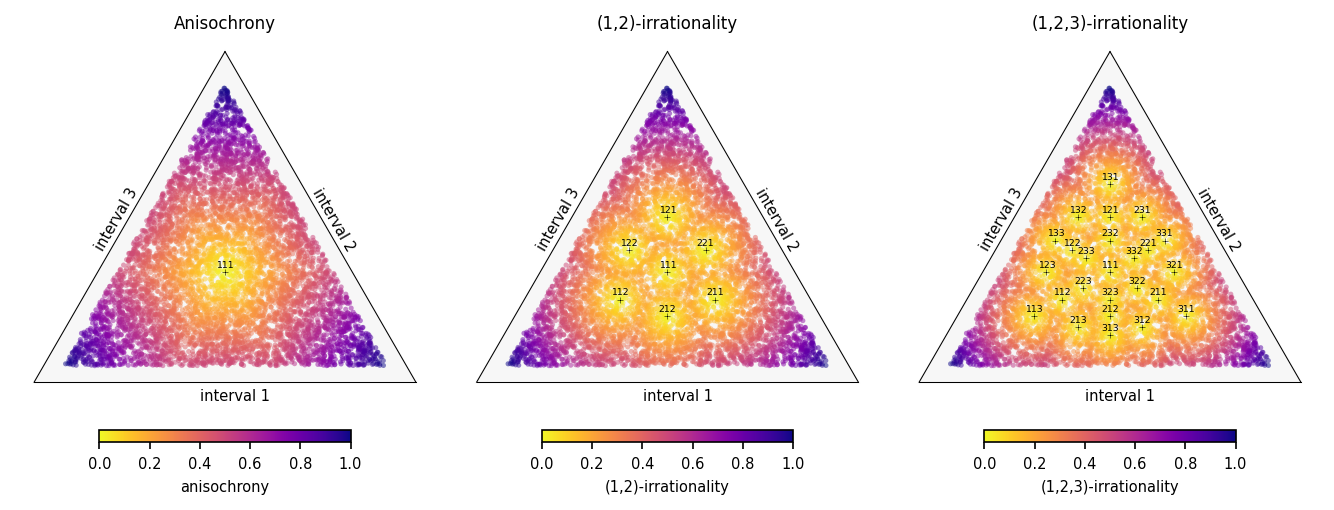

In [112]:
samples = uniform_subsample_triangle(20000, margin=.05)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(9, 3.5), tight_layout=True)
kws = dict(min_dur=0, max_dur=2, scatter_kws=dict(s=6, alpha=.5), cmap='plasma_r', plot_kws=dict(bottom_label_offset=-.1))

ax0.set_title('Anisochrony', fontsize=8)
ternary_motif_plot(samples, np.ones(len(samples)), 
    c=anisochrony(samples), 
    ratio_kws=dict(factors=[1]),
    cbar_kws=dict(label='anisochrony'), 
    ax=ax0, **kws)

ax1.set_title('(1,2)-irrationality', fontsize=8)
ternary_motif_plot(samples, np.ones(len(samples)), 
    c=irrationality(samples, factors=[1, 2]), 
    ratio_kws=dict(factors=[1, 2]),
    cbar_kws=dict(label='(1,2)-irrationality'), 
    ax=ax1, **kws)

ax2.set_title('(1,2,3)-irrationality', fontsize=8)
ternary_motif_plot(samples, np.ones(len(samples)), 
    c=irrationality(samples, factors=[1, 2, 3]), 
    ratio_kws=dict(factors=[1, 2, 3]),
    cbar_kws=dict(label='(1,2,3)-irrationality'), 
    ax=ax2, **kws)

# plt.savefig('figures/anisochrony.pdf')
# plt.savefig('figures/anisochrony.png', dpi=150)

## Measure for datasets

In [113]:
import seaborn as sns
from rhythmplot.helpers import defaults

In [51]:
datasets = dict(
    iemp_css = load_intervals('iemp_css', 'iemp_css-concatenated'),
    degregorio = load_intervals('degregorio2021', 'degregorio2021'),
    fernandez = load_intervals('fernandez2021', 'fernandez2021'),
    nightingale = load_intervals('roeske2020', 'nightingale_songs'),
    zebra_finch = load_intervals('roeske2020', 'zebrafinch'),
    c_persp = load_intervals('burchardt-knornschild2020', 'bat-carollia-perspicillata'),
    s_bil = load_intervals('burchardt-knornschild2020', 'bat-saccopteryx-bilineata'),
    sperm_whale = load_intervals('burchardt-knornschild2020', 'whale-physeter-macrocephalus'),
    filer = load_intervals('filer2021', 'filer2021'),
)

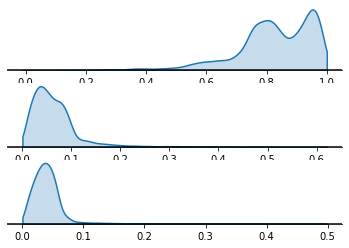

In [107]:
def show_kde(scores, ax=None, **kws):
    if ax is None: ax = plt.gca()
    sns.kdeplot(scores, **defaults(kws, ax=ax, fill=True, lw=1.5, cut=0))
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    ax.set_ylabel('')
    # ax.axis('off')
    ax.axhline(0, lw=1.5, color=kws.get('color', 'k'))

def show_scores(intervals, axs, **kwargs):
    motifs, _ = normalize(ngram_motifs(intervals, length=3))

    anisochronies = anisochrony(motifs)
    show_kde(1 - anisochronies, ax=axs[0], **kwargs)
    
    two_irrationality = irrationality(motifs, factors=[1, 2])
    show_kde(two_irrationality, ax=axs[1], **kwargs)

    three_irrationality = irrationality(motifs, factors=[1, 2, 3])
    show_kde(three_irrationality, ax=axs[2], **kwargs)

fig, axs = plt.subplots(3, 1)
show_scores(datasets['iemp_css'], axs=axs)

(0.0, 0.3)

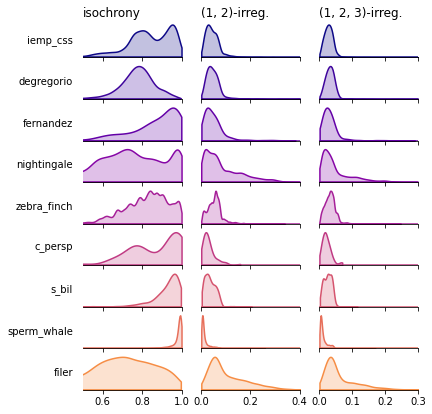

In [115]:
from matplotlib.colors import Normalize

fig, axs = plt.subplots(len(datasets), 3, figsize=(6, len(datasets)*.75), sharex='col')

cmap = plt.get_cmap('plasma')
norm = Normalize(0, len(datasets) + 2)
for i, (dataset, intervals) in enumerate(datasets.items()):
    # if i > 1: continue
    show_scores(intervals, axs=axs[i, :], color=cmap(norm(i)))
    axs[i, 0].annotate(
        dataset, 
        xy=(0, 0.5), xycoords='axes fraction', 
        xytext=(-10, 0), textcoords='offset points',
        va='center', ha='right')

axs[0,0].set_title('isochrony', ha='left', x=0)
axs[0,1].set_title('(1, 2)-irreg.', ha='left', x=0)
axs[0,2].set_title('(1, 2, 3)-irreg.', ha='left', x=0)

# for i in range(lan)
axs[0, 0].set_xlim(.5, 1)
axs[0, 1].set_xlim(0, .4)
axs[0, 2].set_xlim(0, .3)

In [ ]:

intervals = load_intervals('iemp_css', 'iemp_css-concatenated')
motifs, duration = normalize(ngram_motifs(intervals, 3))


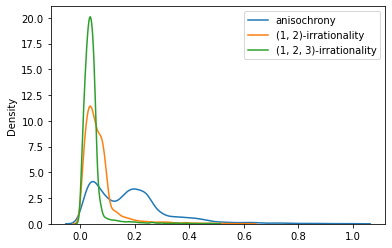

In [33]:
sns.kdeplot(anisochronies, c='C0', label='anisochrony')
sns.kdeplot(two_irrationality, c='C1', label='(1, 2)-irrationality')
sns.kdeplot(three_irrationality, c='C2', label='(1, 2, 3)-irrationality')

plt.legend()

In [20]:
motifs

array([[0.26292671, 0.25992028, 0.47715301],
       [0.25190569, 0.46244009, 0.28565422],
       [0.41640551, 0.25721817, 0.32637632],
       ...,
       [0.37719549, 0.31201066, 0.31079385],
       [0.37386157, 0.37240355, 0.25373488],
       [0.43137292, 0.2939133 , 0.27471378]])

load_intervals('roeske', )